In [1]:
import json
from langchain_openai import ChatOpenAI
from get_llm import get_llm

import os
import subprocess
from IPython.display import Image, display


C:\Users\ananth\anaconda3\envs\agentic_ai_dec2025_2026\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
local_llm = 'gemma-3-12b-it'
llm = get_llm()
llm_json_mode = llm

### One Agent

In [3]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma

from ingest_md import EMBEDDINGS_MODEL, DB_CHROMA_PATH


def get_retriever(k=10):
    """
    after texts are ingested in vectordb, get it as a retriever
    :return:
    """
    embeddings = HuggingFaceEmbeddings(model_name=EMBEDDINGS_MODEL,
                                       model_kwargs={'device': 'cuda'})
    vectordb = Chroma(persist_directory=DB_CHROMA_PATH, embedding_function=embeddings).as_retriever(search_kwargs={"k": k})
    return vectordb


In [4]:
retriever = get_retriever()

C:\Users\ananth\AppData\Local\Temp\ipykernel_83760\3625769994.py:12: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=EMBEDDINGS_MODEL,
C:\Users\ananth\AppData\Local\Temp\ipykernel_83760\3625769994.py:14: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the `langchain-chroma package and should be used instead. To use it run `pip install -U `langchain-chroma` and import as `from `langchain_chroma import Chroma``.
  vectordb = Chroma(persist_directory=DB_CHROMA_PATH, embedding_function=embeddings).as_retriever(search_kwargs={"k": k})


In [5]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage

In [6]:
# ----------------------------------------------------------- Router Prompt ----------------------------------------------------------
router_instructions = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documentation of LangChain and LangGraph.
The vectorstore does not contain general machine learning topics such as regression models or neural networks.
Use the vectorstore for questions on these topics pertaining to LangChain or LangGraph libraries that deal with agentic AI. 
For all else that include but not limited to current events, use web-search.
Return JSON with single key, datasource, that is 'websearch' or 'vectorstore' depending on the question.
Enclose your JSON within code fence ```json and ```
"""

In [7]:
# test cases
query1 = "Explain me the principle of LoRA"
query2 = "Who won the ongoing ODI cricket series between India and South Africa?"
query3 = "Who wrote the book 'Angels and Demons'?"
query4 = "Explain how I can create a react agent using LangChain"
query5 = "Explain how I can create a react agent using LangGraph"

testcases = [query1, query2, query3, query4, query5]

In [8]:
# Test router
for query in testcases:
    result = llm.invoke([SystemMessage(content=router_instructions)] + [HumanMessage(content=query)])
    print(result.content)


```json
{"datasource": "websearch"}
```
```json
{
  "datasource": "websearch"
}
```
```json
{
  "datasource": "websearch"
}
```
```json
{"datasource": "vectorstore"}
```
```json
{"datasource": "vectorstore"}
```


In [9]:
rag_prompt = """You are an assistant for question-answering tasks. 

Here is the context to use to answer the question:

{context} 

Think carefully about the above context. 

Now, review the user question:

{question}

Provide an answer to this questions using only the above context. 

Keep the answer formal and concise.

Answer:
"""

In [10]:
import operator
from typing_extensions import TypedDict
from typing import List, Annotated

# class AgentState(TypedDict):
#     messages: Annotated[list[AnyMessage], operator.add]


class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in, each graph node.
    """
    question : str # User question
    documents : str # concatenated string of retrieved documents or these can be concatenated web search results
    generation : str # LLM generation - this holds the final response
    web_search : str # Binary decision to run web search


## Define the web search tool - replace the TAVILY_API_KEY

In [11]:
### Search
from langchain_community.tools.tavily_search import TavilySearchResults
os.environ["TAVILY_API_KEY"] = ''
web_search_tool = TavilySearchResults(k=3)

C:\Users\ananth\AppData\Local\Temp\ipykernel_83760\2752108202.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults(k=3)


In [12]:
### Nodes
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Write retrieved documents to documents key in state
    documents = retriever.invoke(question)
    documents = "\n\n".join(doc.page_content for doc in documents)
    return {"documents": documents}

def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]  # user's question
    documents = state["documents"]  # retrieved docs from vector db
    
    # RAG generation
    rag_prompt_formatted = rag_prompt.format(context=documents, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"generation": generation}

    
def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = []  # state.get("documents", [])
    
    # Web search
    docs = web_search_tool.invoke({"query": question})
    
    web_results = "\n".join([d["content"] for d in docs])
    # web_results = Document(page_content=web_results)
    documents.append(web_results)  # list of search results, which are strings data type
    
    return {"documents": documents}



In [13]:
# Define edges

def route_question(state):
    """
    Route question to web search or RAG 

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    print("state in router = ", state)
    route_question = llm_json_mode.invoke([SystemMessage(content=router_instructions)] + [HumanMessage(content=state["question"])])
    route_question = route_question.content.split("```json")[-1].split("```")[0]
    source = json.loads(route_question)['datasource']
    if source == 'websearch':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


In [14]:
class MyAgentApp:
    def __init__(self, system_prompt=""):
        self.system_prompt = system_prompt
        
        # initialising graph with a state 
        graph = StateGraph(GraphState)
        
        # adding nodes 
        graph.add_node("websearch", web_search)
        graph.add_node("retrieve", retrieve)
        graph.add_node("generate", generate)

        # Build graph
        graph.set_conditional_entry_point(
            route_question,  # function that returns either "websearch" or "retrieve"
            {
                "websearch": "websearch",
                "vectorstore": "retrieve",
            },
        )
        graph.add_edge("websearch", "generate")
        graph.add_edge("generate", END)
        graph.add_edge("retrieve", "generate")
        
        self.graph = graph.compile()
        
        # self.tools = {t.name: t for t in tools}
        # self.model = model.bind_tools(tools)



In [15]:
# display(
#     Image(
#         graph.get_graph().draw_mermaid_png(
#             draw_method=MermaidDrawMethod.API,
#         )
#     )
# )

In [16]:
app = MyAgentApp(system_prompt="")


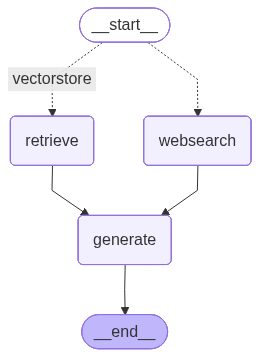

In [17]:
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
question1 = "What is LoRA?"
question2 = "Who won the recently concluded T20I series between India and South Africa? Who got the man of the series?"
question2 = "Who won the IPL qualifier 2 yesterday? Today is 2nd June 2025."

question3 = "Explain linear regression"

result = app.graph.invoke({"question": question3})
print(result["generation"].content)